In [1]:
import pandas as pd
import numpy as np
import gensim
from konlpy.tag import Okt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.cluster import KMeans
import re
import ast
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tqdm import tqdm
import time

In [2]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\cg063\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [3]:
train = pd.read_json('./origin_data_modify/train_mod3.json', typ='frame')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109282 entries, 0 to 109281
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   tags                         109282 non-null  object
 1   id                           109282 non-null  int64 
 2   plylst_title                 109282 non-null  object
 3   songs                        109282 non-null  object
 4   like_cnt                     109282 non-null  int64 
 5   updt_date                    109282 non-null  object
 6   mapping_plylst_cnt           109282 non-null  int64 
 7   mapping_plylst_cnt_category  109282 non-null  object
 8   song_cnt                     109282 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 8.3+ MB


### 1. 필요한 컬럼만 남기기 & 태그 특수문자 제거

In [42]:
# 필요한 컬럼만 남기기
train = train.iloc[:, :6]
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,['Pop'],123815,1 1 환상의 케미스트리 211,"[243181, 520307, 291514, 496987, 285795, 68548...",0,2019-03-27 15:27:43.000
1,['팝'],114252,1 HITS OF DECADE SPECIAL,"[527878, 344149, 156954, 492893, 33166, 218207...",1,2013-10-12 20:53:50.000
2,['팝'],50564,1 HITS OF DECADE SPECIAL 2,"[60025, 326802, 82991, 533287, 404318, 82686, ...",5,2009-07-11 21:37:42.000
3,['Pop'],62278,100% 로맨틱 조지 마이클 223,"[366485, 435804, 442680, 538949, 263360, 29495...",0,2019-03-27 15:27:44.000
4,"['기분좋은', '100번']",148495,100번 들어도 기분좋은 가요,"[208186, 155952, 669617, 438439, 397412, 60398...",4,2016-10-31 13:59:41.000
...,...,...,...,...,...,...
109277,['일렉'],56144,00 Party 일렉트로댄스,"[256418, 183424, 431998, 654442, 354592, 24132...",7,2018-02-06 16:02:42.000
109278,['일렉'],58768,00 Electronica__EDM,"[673003, 251403, 617690, 441958, 436128, 62788...",5,2020-01-05 00:24:22.000
109279,['일렉'],110536,0 일렉듣고 광질준비 O K _ElecVVIP,"[349306, 93890, 651902, 46845, 362347, 330768,...",173,2012-11-29 14:34:56.000
109280,"['비오는날', '추억', '회상']",106660,비오는날 듣기 좋은 연주곡 모음,"[79329, 51922, 173875, 216115, 422584, 509605,...",6,2015-10-06 11:45:24.000


In [43]:
# train['tags]를 str -> 리스트로 변환하기

train['tags'] = train['tags'].apply(lambda x: ast.literal_eval(x))
type(train['tags'][0])

list

In [44]:
# 특수문자 '_'가 있는 행 찾기
# '_'가 있는 행 찾기
rows_with_underscore = train['tags'][train['tags'].apply(lambda x: any('_' in tag for tag in x))]
rows_with_underscore

200                           [그래미, Grammy, Kendrick_Lamar]
267       [휴식, 소나기, 흐리고_비, 생각_사색_명상, 센치한_우울한, 부드러운_잔잔한, ...
303               [힙합, weeflow, HipHop, kxan, 힙_합, hiphopb]
304               [힙합, weeflow, HipHop, kxan, 힙_합, hiphopb]
658                                         [기분_전환, 신의_목소리]
                                ...                        
109170    [비오는날, 밤, 새벽, 직접찾은플레이리스트, midnight, 몽환, Pop, h...
109212               [담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]
109232                      [음악, 잔잔한, 새벽, 몽환, 새벽_밤, 감성, 인디]
109233    [카페음악, 신나는_음악, dance, 즐거운_음악, 댄스_음악, 드라이브, 힐링,...
109237    [카페_음악, 밤, space, UNIVERSE, 새벽, 우주, 방안, 조용한음악,...
Name: tags, Length: 2153, dtype: object

In [45]:
# 특수 문자를 제거하는 함수 정의
def remove_special_characters(tag_list):
    cleaned_tags = []
    for tag in tag_list:
        cleaned_tag = re.sub(r'[^\uAC00-\uD7A30-9a-zA-Z\s]', '', tag).replace(" ", "")
        cleaned_tags.append(cleaned_tag)
    return cleaned_tags

In [46]:
# 함수 적용
train['tags'] = train['tags'].apply(remove_special_characters)

In [47]:
# 알맞게 제거 되었는지 확인
train.iloc[[200, 267, 303], :]

,tags,id,plylst_title,songs,like_cnt,updt_date
200,"[그래미, Grammy, KendrickLamar]",118371,Kendrick Lamar와 논란의 Grammy,"[158000, 166761, 655888, 539180, 606851, 15869...",14,2016-02-23 17:02:02.000
267,"[휴식, 소나기, 흐리고비, 생각사색명상, 센치한우울한, 부드러운잔잔한, 비또는눈]",99454,Rainy day,"[219025, 476707, 371788, 35117, 216955, 98472,...",0,2020-04-20 03:00:46.000
303,"[힙합, weeflow, HipHop, kxan, 힙합, hiphopb]",99473,Wee the fuxxing flow Vol 2,"[347310, 184460, 111628, 520738, 567069, 31478...",18,2020-03-25 14:01:14.000


In [48]:
train.to_json('./origin_data_modify/train_mod4.json')

### 2. 군집화

In [4]:
train = pd.read_json('./origin_data_modify/train_mod4.json', typ='frame')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109282 entries, 0 to 109281
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          109282 non-null  object
 1   id            109282 non-null  int64 
 2   plylst_title  109282 non-null  object
 3   songs         109282 non-null  object
 4   like_cnt      109282 non-null  int64 
 5   updt_date     109282 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.8+ MB


In [5]:
train.head()

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[Pop],123815,1 1 환상의 케미스트리 211,"[243181, 520307, 291514, 496987, 285795, 68548...",0,2019-03-27 15:27:43.000
1,[팝],114252,1 HITS OF DECADE SPECIAL,"[527878, 344149, 156954, 492893, 33166, 218207...",1,2013-10-12 20:53:50.000
2,[팝],50564,1 HITS OF DECADE SPECIAL 2,"[60025, 326802, 82991, 533287, 404318, 82686, ...",5,2009-07-11 21:37:42.000
3,[Pop],62278,100% 로맨틱 조지 마이클 223,"[366485, 435804, 442680, 538949, 263360, 29495...",0,2019-03-27 15:27:44.000
4,"[기분좋은, 100번]",148495,100번 들어도 기분좋은 가요,"[208186, 155952, 669617, 438439, 397412, 60398...",4,2016-10-31 13:59:41.000


In [6]:
train['tags'][11219] # 11215 11219

['트렌디', '매장음악', '카페', '감각적인', '리드미컬한', '그루브', '랩노래', '기분전환', '유니크', '빈티지']

- stemming

In [150]:
# words = train['tags'][11219]

# stemmer = PorterStemmer()
# okt = Okt()

# for word in words:
# 	print(okt.nouns(word))

['트렌디']
['매장', '음악']
['카페']
['감각']
[]
['그루', '브']
['랩', '노래']
['기분', '전환']
['유니크']
['빈티']


In [7]:
# train['tags'] unset 진행
tags_list = train.explode('tags')['tags'].values.tolist()
len(tags_list)

457923

In [8]:
# 유니크 태그만 남기기
unique_tag = list(set(tags_list))
len(unique_tag) # 28631개

28631

In [9]:
unique_tag

['',
 '끈적끈적한여름밤에',
 '복고댄스',
 '성인가요Top100',
 'ryan',
 'nba2k19',
 '븝리티시',
 'Firstlove',
 '김세정',
 '벤치에앉아듣는',
 '인터스텔라',
 '몽한',
 'vlog',
 '아쉬탕가요가',
 '약속',
 'StayAtHome',
 '테이크아웃',
 '떨어지는날',
 '상실의시대',
 '안정감',
 '미친음색',
 'sundayvibes',
 '우클렐레',
 'Bars',
 '이제안녕',
 'selling',
 '지디',
 '내가좋아하는곡들',
 '하플버',
 '뚱기뚱기',
 '돗때기시장',
 '체력증강',
 '감상힙합',
 'coffeepop',
 '졸음운전예방',
 'Depression',
 '파운드케익',
 '뷰티',
 '센티멘탈',
 '후로그',
 'rockisnotdead',
 '전공',
 '리시차',
 '켄지',
 '계속듣게되는',
 '받습니다',
 '청명',
 '투스텝',
 '스물아홉',
 '리한나',
 '상상연애',
 'BebeRexha',
 '웨터',
 '블랙넛',
 '자아',
 '깜찍한',
 '봄드라마OST',
 '취업',
 '세탁방',
 '뮤지컬풍노래',
 '힘들었지',
 'BigRoom',
 '다양성',
 '이불속에',
 '찰짐',
 '팬심',
 '유니세프',
 '댄스홀',
 '라틴음악',
 '휴가철듣기좋은노래',
 '여행이필요할때',
 '명확한',
 '감동적',
 '댓글많이',
 '아메리칸송북',
 '먹방',
 '숨은',
 '토리에',
 '음악모음',
 'qlalf',
 '듣기좋은최신곡',
 '그대를위로하는',
 '저메인듀프리',
 '어린이찬양',
 '집중잘되는음악',
 '홀리데이랜드',
 '삭커',
 '인테리어',
 '아직넣지못한노래가',
 'Covid',
 '멍에',
 '은진보고있나',
 '합창',
 '인기휴식힐링스트레스태교클래식',
 '잔잔한그루브',
 'hardcorepunk',
 '슈퍼비',
 '1000곡',
 'Bosanova',
 '지루한',
 '상반기결산',

- 유사한 단어들끼리 군집화 후 군집 별 lable 달아주기

In [10]:
okt = Okt()

tagged_data = [] # 89개의 TaggedDocument
for i in range(len(unique_tag)) :
  tagged_document = TaggedDocument(words=unique_tag[i], tags=[str(unique_tag[i])])
  tagged_data.append(tagged_document)

len(tagged_data)

28631

In [11]:
sorted_word_list = sorted(unique_tag, key=len, reverse=True)
sorted_word_list

['외모와연주실력모두갖춘클래식아티스트',
 'BillboardDecember',
 '5secondsofsummer',
 '매장커피숍호텔로비추천인기클래식',
 '유어어어아아아어어어어어엉우아아',
 'FuturisticSwaver',
 'ProgressiveHouse',
 '피아노바이올린협주곡관현악클래식',
 '사진작가김경민님의사진출저입니다',
 'socialdistancing',
 'BlueBottleCoffee',
 '커피숍매장라운지자장가추천클래식',
 '프로듀스101시즌2포지션평가곡',
 'TheSoundofCHANEL',
 '카페커피숖호텔라운지에서듣는재즈',
 'SebastienTellier',
 '인기휴식힐링스트레스태교클래식',
 'holidayland2019',
 '책읽을때적당히틀어놓기좋은음악',
 '휴식시간휴가에들으면좋은클래식',
 '산다라박머리로가요계를씹어먹어',
 '매장커피숖호텔라운지추천클래식',
 '나혼자들을플레이리스트입니다후',
 '스트레스해소인기추천힐링클래식',
 '망할게뻔한모험을부추기는노래들',
 'AnthonyHamilton',
 '매장커피숍호텔라운지추천클래식',
 'Justinhartinger',
 '5Secondofsummer',
 'TheRhapsodyTour',
 '코로나는코리아를이길수없습니다',
 'thelonelyisland',
 'GirlfromIpanema',
 'SteveLillywhite',
 '매장커피숍추천BGM인기클래식',
 '믿고들어보는어나니머스아티스트',
 'LIVEFOREVERLONG',
 '안준성한보람고남수정병균김보아',
 'WELOVEVOCAELEDM',
 'alternativerock',
 'SeptemberCompil',
 'LeagueofLegends',
 '한재호김승수송수윤YUE이창현',
 '가을이라더귀에꽂히는감성사운드',
 '하이네켄프레젠트스타디움입니다',
 'electronicmusic',
 'markdeclivelowe',
 '욕하고싶지만교양또한지키고싶다',
 'TheChainsmokers',
 

In [13]:
len(sorted_word_list[0])

18

In [14]:
# Doc2Vec 적용(문서 -> 숫자)
# dm=0 => DBOW 알고리즘 사용(단어 순서 고려 X)
# epochs => 같은 데이터에 대해 3번 학습을 반복

model = Doc2Vec(vector_size=20, dm=0, epochs=40)
model.build_vocab(tagged_data)

In [15]:
model.corpus_count

28631

In [16]:
# train 사용
model.train(corpus_iterable=tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

- Doc2Vec의 결과 확인

In [17]:
model.dv.most_similar('kpop')

[('kpo', 0.9871180057525635),
 ('kpip', 0.9856948256492615),
 ('ukpop', 0.974844217300415),
 ('punk', 0.9692235589027405),
 ('koreahiphop', 0.9690225124359131),
 ('kokobop', 0.9666101932525635),
 ('pickwon', 0.9664284586906433),
 ('postpunk', 0.9656044840812683),
 ('punkrock', 0.9652943015098572),
 ('korerap', 0.965058445930481)]

In [18]:
model.dv.most_similar('크리스마스')

[('메리크리마스', 0.9822022318840027),
 ('메리크리스마스', 0.9744406342506409),
 ('크리스마스테마', 0.9608067274093628),
 ('크리스마스러버', 0.9535830020904541),
 ('크리스마스를', 0.9508242011070251),
 ('미리메리크리스마스', 0.9494024515151978),
 ('마리슈', 0.9482586979866028),
 ('라스트크리스마스', 0.9451663494110107),
 ('크리스마스이브', 0.9448142647743225),
 ('카리스마', 0.9407587051391602)]

In [19]:
model.dv.most_similar('캐롤')

[('캐논', 0.9658557772636414),
 ('샤캐', 0.9402022957801819),
 ('롤', 0.938514769077301),
 ('캐럴', 0.9383792877197266),
 ('캐롤킹', 0.936622679233551),
 ('캐럿', 0.9355429410934448),
 ('잠캐롤', 0.915497362613678),
 ('캐쥬얼펍', 0.9101352691650391),
 ('글램', 0.898898184299469),
 ('징글', 0.8964603543281555)]

In [20]:
model.dv.most_similar('여행')

[('여행의', 0.986977219581604),
 ('여름여행', 0.9687496423721313),
 ('잉여', 0.9658711552619934),
 ('여긴', 0.9644433259963989),
 ('배낭여행', 0.9642677903175354),
 ('숙행', 0.9601126313209534),
 ('세계여행', 0.9515103101730347),
 ('참여', 0.9510480761528015),
 ('여행자', 0.9475475549697876),
 ('혼여행', 0.9420120120048523)]

In [21]:
model.dv.most_similar('Pop')

[('Poppop', 0.9842923283576965),
 ('PopRap', 0.9742347598075867),
 ('PianoTrio', 0.9701758027076721),
 ('SophistiPop', 0.965798020362854),
 ('Up', 0.9591637849807739),
 ('PostBop', 0.9585882425308228),
 ('Poplatino', 0.9525443315505981),
 ('HipHopRap', 0.9490280747413635),
 ('Koop', 0.9479782581329346),
 ('TomPetty', 0.9475904107093811)]

In [21]:
model.dv.most_similar('발라드')

[('발라', 0.9861674308776855),
 ('발라드및', 0.9849256277084351),
 ('롹발라드', 0.982241690158844),
 ('랩발라드', 0.9754948019981384),
 ('갓발라드', 0.9684540033340454),
 ('발라드랩', 0.9639233946800232),
 ('슬픈발라드', 0.9444116950035095),
 ('발라드락', 0.9408860206604004),
 ('팀발랜드', 0.9353188872337341),
 ('이별발라드', 0.9345559477806091)]

In [22]:
model.dv.vectors.shape

(28631, 20)

In [23]:
model.dv.vectors

array([[-0.02615408, -0.02989563, -0.04940377, ...,  0.04612811,
        -0.04750933, -0.01729043],
       [-0.03736467, -0.2247069 , -0.09558295, ..., -0.07919396,
         0.5347969 , -0.29551727],
       [-0.20780331, -0.14383762,  0.25698134, ..., -0.03754301,
         0.0170473 ,  0.2132769 ],
       ...,
       [-0.3583898 ,  0.01669301, -0.2887884 , ...,  0.29520774,
         0.5450994 ,  0.18533196],
       [-0.33773407,  0.04486322,  0.07908817, ...,  0.0018119 ,
         0.05913388,  0.7707797 ],
       [-0.2523314 ,  0.15628836,  0.13073765, ..., -0.16601972,
         0.03201874,  0.31976518]], dtype=float32)

In [24]:
doc_representations = model.dv.vectors
doc_representations.shape

(28631, 20)

In [25]:
df_new = pd.DataFrame()
df_new['tag_name'] = model.dv.index_to_key # 영화마다 군집화하게되면 군집별로 번호가 붙인다
df_new.head()

,tag_name
0,
1,끈적끈적한여름밤에
2,복고댄스
3,성인가요Top100
4,ryan


- 군집화

In [26]:
# k-means 군집화 알고리즘을 사용해 클러스터 개수를 조절하면서 왜곡을 계산

distortions = [] # 왜곡값을 저장할 빈 리스트 생성

for k in tqdm(range(1, 100), desc="K-Means Clustering Progress"):  # range 범위 내의 k에 대해 반복
    kmeans = KMeans(n_clusters=k, n_init=10)  # n_init 초기화 횟수
    kmeans.fit(doc_representations)  # 비지도 학습 수행
    distortions.append(kmeans.inertia_)

K-Means Clustering Progress: 100%|██████████| 99/99 [10:34<00:00,  6.41s/it]


In [27]:
distortions

[21727.8984375,
 18565.666015625,
 17312.15625,
 16532.44140625,
 15947.734375,
 15562.6875,
 15099.517578125,
 14801.1591796875,
 14522.64453125,
 14297.421875,
 14090.259765625,
 13908.2294921875,
 13749.2626953125,
 13595.9287109375,
 13464.4951171875,
 13343.0556640625,
 13222.365234375,
 13105.279296875,
 12989.025390625,
 12896.984375,
 12788.0546875,
 12715.6083984375,
 12615.916015625,
 12539.583984375,
 12447.279296875,
 12390.3994140625,
 12314.4033203125,
 12248.92578125,
 12179.951171875,
 12132.74609375,
 12044.46484375,
 12008.0849609375,
 11935.220703125,
 11844.19921875,
 11805.95703125,
 11769.2314453125,
 11697.3017578125,
 11651.0546875,
 11603.5927734375,
 11561.4375,
 11522.916015625,
 11461.494140625,
 11434.6015625,
 11379.435546875,
 11332.576171875,
 11283.3173828125,
 11256.3349609375,
 11197.833984375,
 11161.4267578125,
 11129.9208984375,
 11089.837890625,
 11061.693359375,
 11021.638671875,
 10980.2197265625,
 10947.6865234375,
 10917.48828125,
 10883.36328

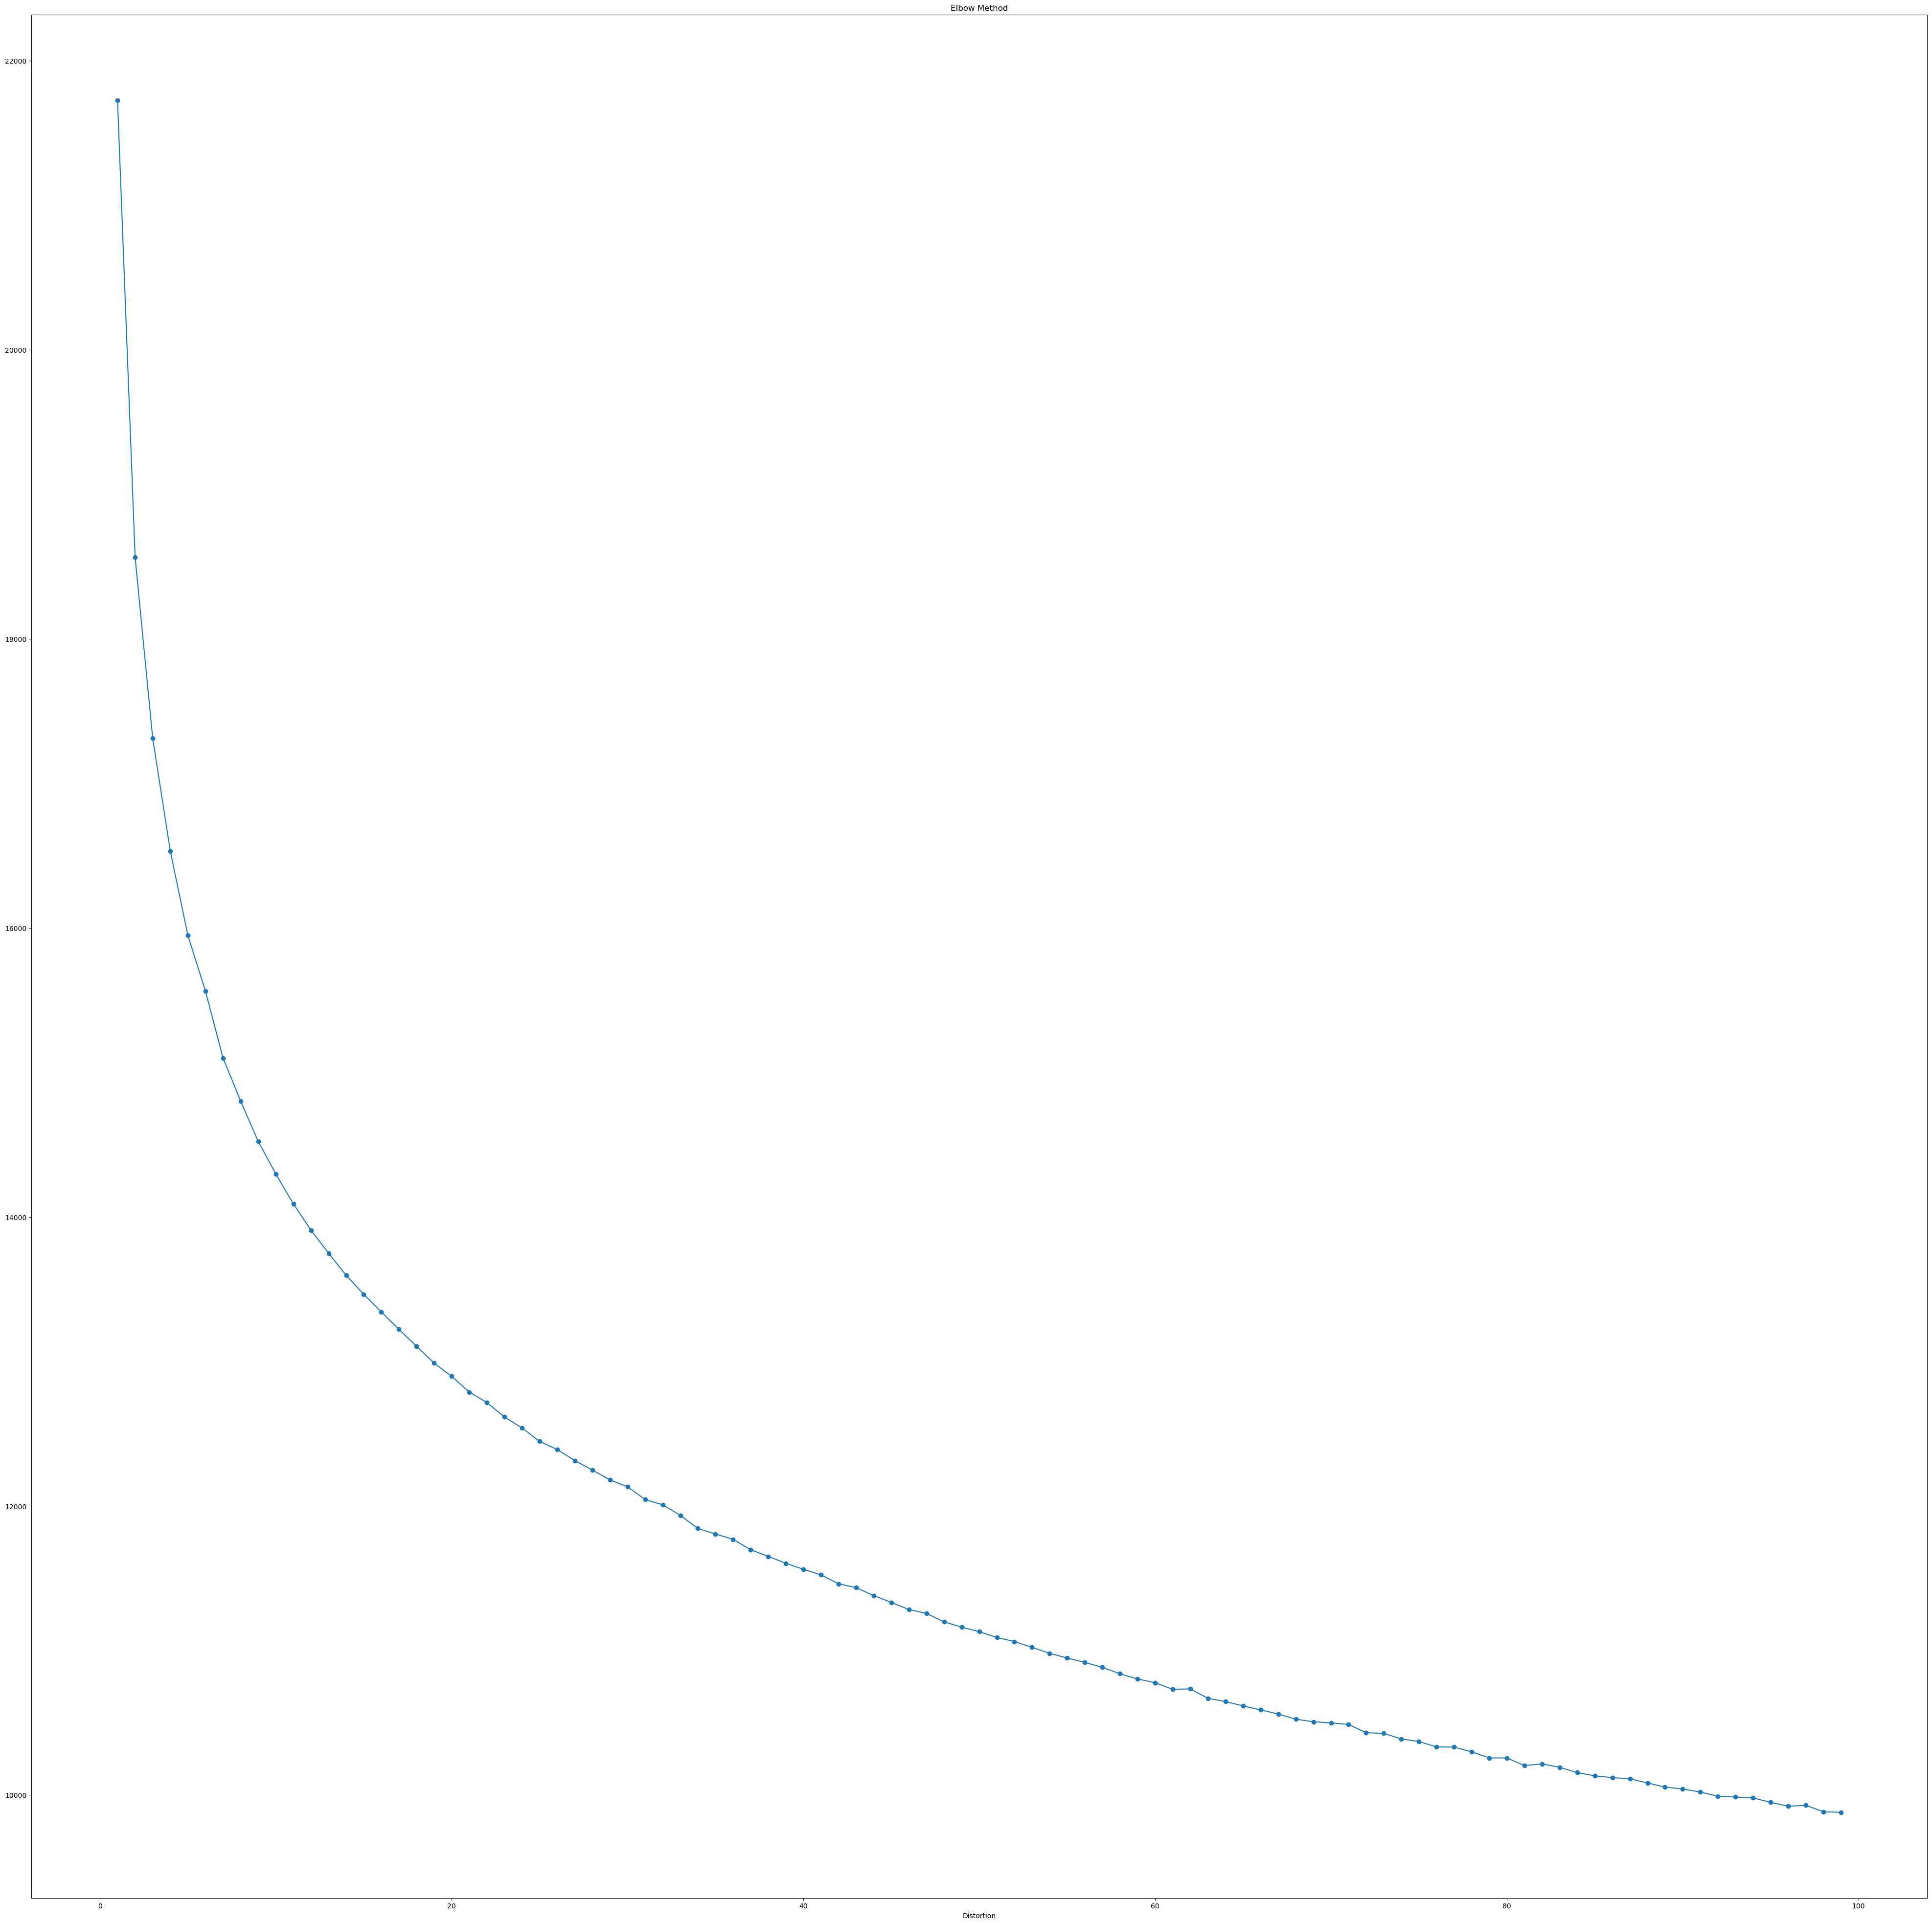

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))
plt.plot(range(1, 100), distortions, 'o-')
plt.xlabel('k')
plt.xlabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [29]:
selected_k=100
kmeans = KMeans(n_clusters=selected_k, n_init=10)
kmeans.fit(doc_representations)
kmeans.labels_

array([33, 53, 69, ..., 68,  8, 16])

In [30]:
df_new['그룹'] = kmeans.labels_
df_new['그룹'].value_counts()

33    1205
27     592
48     480
8      469
16     458
      ... 
23     122
81     113
77     112
21     112
95      38
Name: 그룹, Length: 100, dtype: int64

In [31]:
df_new.loc[df_new['그룹'] == 0, :]

,tag_name,그룹
68,라틴음악,0
78,음악모음,0
84,집중잘되는음악,0
158,음악에,0
194,음악의선물,0
...,...,...
28410,느낌있는음악,0
28502,호텔음악,0
28512,젊음,0
28521,태교음악,0


In [32]:
df_new.loc[df_new['그룹'] == 15, :]

,tag_name,그룹
45,받습니다,15
153,영머니,15
296,샤이니종현,15
569,힐링뮤지들입니다,15
607,제시맥카트니,15
...,...,...
27730,푸르니에,15
28108,뉴욕이가까워집니다,15
28253,해외포크스테디,15
28303,애니메이션,15


In [33]:
df_new.loc[df_new['그룹'] == 50, :]

,tag_name,그룹
6,븝리티시,50
37,뷰티,50
38,센티멘탈,50
99,지루한,50
156,파티곡,50
...,...,...
28404,파이팅,50
28425,파워라이딩,50
28488,다양한크루,50
28572,죄와벌,50


In [34]:
df_new.loc[df_new['그룹'] == 75, :]

,tag_name,그룹
22,우클렐레,75
28,하플버,75
148,아침,75
217,심야아이돌,75
349,요한스트라우스,75
...,...,...
28088,우주대스타,75
28312,아담,75
28401,스무스,75
28523,로우파이,75


In [35]:
df_new.loc[df_new['그룹'] == 99, :]

,tag_name,그룹
123,신음,99
289,평안을,99
309,신난닭,99
375,진지,99
698,신맛,99
...,...,...
28159,최보군,99
28210,신상,99
28318,위켄드내한,99
28412,신쥬쿠,99
